# Анализ продаж маркетплейса

Нашел интересный датафрейм на Kaggle, решил проанализировать его на наличие закономерностей. 

### Цель работы:
- Выявление статистически значимых зависимостей внутри датафрейма, которые помогли бы маркетплейсу максимизировать прибыль.

### План:
- Сбор и обработка данных
- Разведочный анализ
- Анализ столбцов, связанных с покупателями
- Анализ столбцов, связанных с товаром
- Анализ столбцов, связанных с работой маркетплейса (способ оплаты/доставки и тд)

Отмечу, что я не буду давать рекомендации маркетплейсу, так как не имею требуемых знаний, а просто нахожу закономерности в данных, которые более квалифицированные коллеги уже могли бы интерпретировать корректно.

## Установка датафрейма и зависимостей
Для получения датафрейма у Kaggle есть специальная библиотека, я скачал данные и перенес их в папку /DATA, чтобы было удобнее запустить ноутбук впервые.

In [3]:
# !pip install kagglehub

In [58]:
import kagglehub

# path = kagglehub.dataset_download("iamsouravbanerjee/customer-shopping-trends-dataset")

# print("Path to dataset files:", path)

Установка зависимостей и параметров по умолчанию

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

## Обработка данных

Проверим, что датафрейм получен корректно, посмотрим на количества пропусков и типы данных

In [3]:
df = pd.read_csv('DATA/shopping_trends_updated.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

Все четко, проверим датафрейм на наличие дубликатов

In [4]:
df.duplicated().sum()

0

Дубликатов также нет

## Разведочный анализ

Посмотрим на описательную таблицу для числовых колонок

In [5]:
df.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


Все данные выглядят максимально равномерными, так как в рамках одной колонки между всеми квартилями примерно одинаковое расстояние

Также посмотрим на корреляционную матрицу

In [6]:
df.corr(numeric_only=True)

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
Customer ID,1.000000,-0.004079,0.011048,0.001343,-0.039159
Age,-0.004079,1.000000,-0.010424,-0.021949,0.040445
Purchase Amount (USD),0.011048,-0.010424,1.000000,0.030776,0.008063
Review Rating,0.001343,-0.021949,0.030776,1.000000,0.004229
Previous Purchases,-0.039159,0.040445,0.008063,0.004229,1.000000


Корреляция между числовыми колонками отсутствует

## Анализ столбцов, связанных с покупателями

Посмотрим на то, как распределены полы

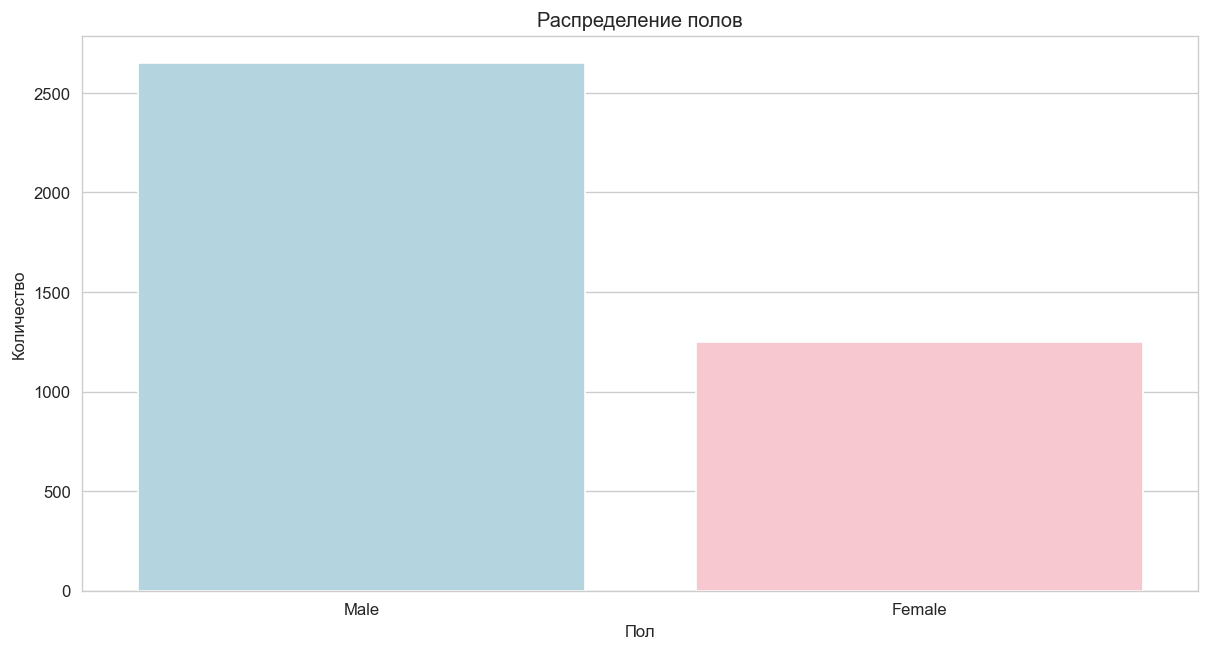

In [221]:
plt.figure(figsize=(12, 6), dpi=120)

sns.countplot(data=df, x='Gender', palette=['lightblue', 'pink'])
plt.title('Распределение полов')
plt.xlabel('Пол')
plt.ylabel('Количество');

#### Соотношение мужчин к женщинам выглядит примерно как 2 к 1. Проверим данную гипотезу с помощью гипотезы для долей:

**H0**: *Доля мужчин в генеральной совокупности = 2/3*

**H1**: *Доля мужчин в генеральной совокупности ≠ 2/3*

In [186]:
from statsmodels.stats.proportion import proportions_ztest

value = (df['Gender'] == 'Male').sum()
count = df.shape[0]

z_stat, p_value = proportions_ztest(value, count, 2/3)

# Вывод результатов
print(f'Z-статистика: {z_stat:.4f}')
print(f'P-значение: {p_value:.4f}')

Z-статистика: 1.7850
P-значение: 0.0743


*Нулевая гипотеза не отвергается*, ***соотношение полов и вправду можно принять за 2 к 1***.

Посмотрим на распределение остальных количественных признаков

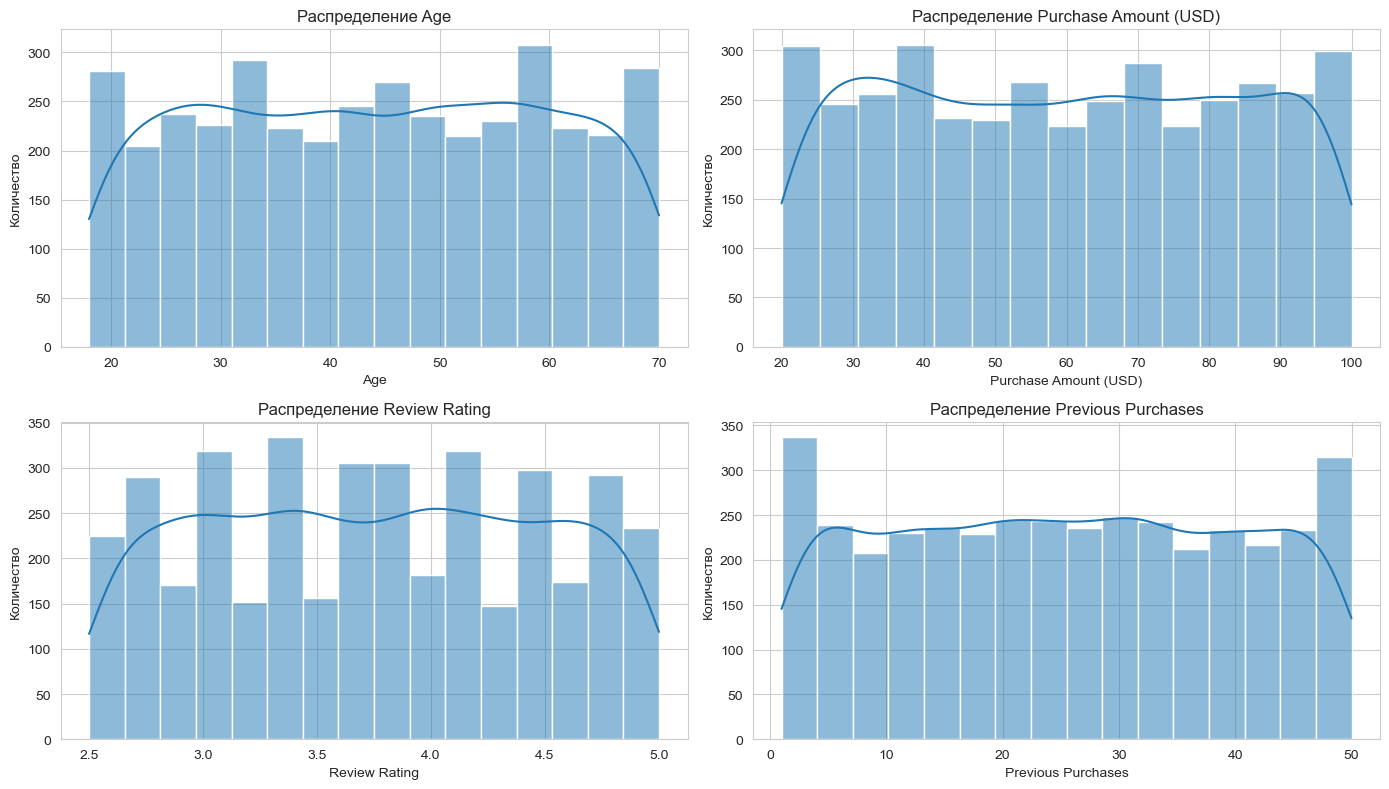

In [69]:
fig, ax = plt.subplots(2, 2, figsize = (14, 8))
columns = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    
    sns.histplot(data=df, x=column, kde=True, ax=ax[row, col])
    ax[row, col].set_title(f'Распределение {column}')
    ax[row, col].set_xlabel(column)
    ax[row, col].set_ylabel('Количество')
    plt.tight_layout();

#### Все распределения выглядят равномерными, циклично проверим это для каждого признака с помощью критерия `Хи-квадрат`:

**H0**: *Распределение равномерное*

**H1**: *Распределение отлично от равномерного*

In [70]:
for i, column in enumerate(columns): 
    ages_dist = df[column].value_counts().values
    exp_dist = [sum(ages_dist) / len(ages_dist)] * len(ages_dist)

    _, p_value = stats.chisquare(ages_dist, exp_dist)
    print(f"P-значение для {column}: {p_value}")

P-значение для Age: 0.8276060881036548
P-значение для Purchase Amount (USD): 0.5605363926686349
P-значение для Review Rating: 6.081240018915435e-15
P-значение для Previous Purchases: 0.30949815496626737


***Распределение возрастов, величины оплаты и кол-ва педыдущих покупок равномерны, в отличие от распределения рейтингов.*** Видимо, люди часто округляют оценку до какого-либо приятного числа.

Из корреляционной матрицы мы знаем, что они никак не зависят друг от друга, поэтому анализ их взаимосвязи бессмысленен.

#### Проверим, изменяются ли эти признаки с полом. 

Проведем `z-тест` для каждого признака, разделенного по полу. `Z-тест` выбран, так как распределение отлично от нормального, а в каждой из выборок будет достаточно значений для асимптотической нормальности средних значений по `ЦПТ`.

**H0**: *Средние значения у мужчин и женщин равны.*

**H1**: *Средние значения у мужчин и женщин различны.*

P-значение для Age: 0.863
P-значение для Purchase Amount (USD): 0.3805
P-значение для Review Rating: 0.6103
P-значение для Previous Purchases: 0.025


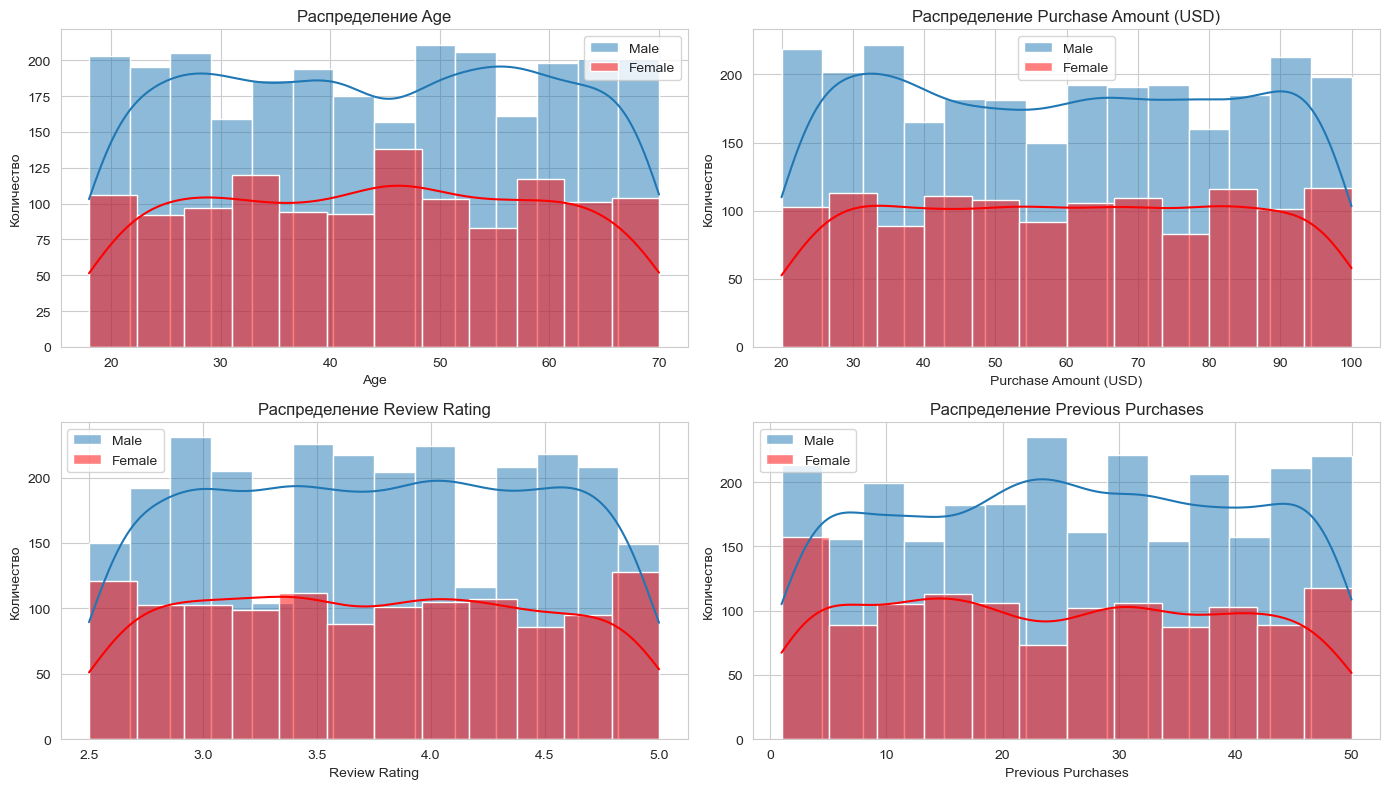

In [219]:
from statsmodels.stats.weightstats import ztest

fig, ax = plt.subplots(2, 2, figsize = (14, 8))
columns = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    
    male_dist = df[df['Gender'] == 'Male'][column]
    female_dist = df[df['Gender'] == 'Female'][column]
    print(f'P-значение для {column}: {ztest(male_dist, female_dist)[1].round(4)}')
    
    sns.histplot(male_dist, kde=True, ax=ax[row, col], label='Male', color='#1f77b4')
    sns.histplot(female_dist, kde=True, ax=ax[row, col], label='Female', color='red')
    ax[row, col].set_title(f'Распределение {column}')
    ax[row, col].set_xlabel(column)
    ax[row, col].set_ylabel('Количество')
    ax[row, col].legend()
    plt.tight_layout();

Видим *статистически значимое различие в средних значениях количества предыдущих покупок у мужчин и женщин*. Посмотрим на эту разницу.

In [210]:
male_prev_mean = df[df['Gender'] == 'Male']['Previous Purchases'].mean()
female_prev_mean = df[df['Gender'] == 'Female']['Previous Purchases'].mean()
print(f'Примерная разница между средним количеством предыдущих покупок у мужчин и женщин: {round(male_prev_mean - female_prev_mean, 2)}')

Примерная разница между средним количеством предыдущих покупок у мужчин и женщин: 1.11


То есть ***в среднем у мужчин больше предыдущих покупок на 1, нежели у женщин***. В остальных признаках разницу мы не можем подтвердить.

## Анализ столбцов, связанных с товаром

Перейдем к номинативным признакам, начнем с признаков товаров. Построим распределение их количества.

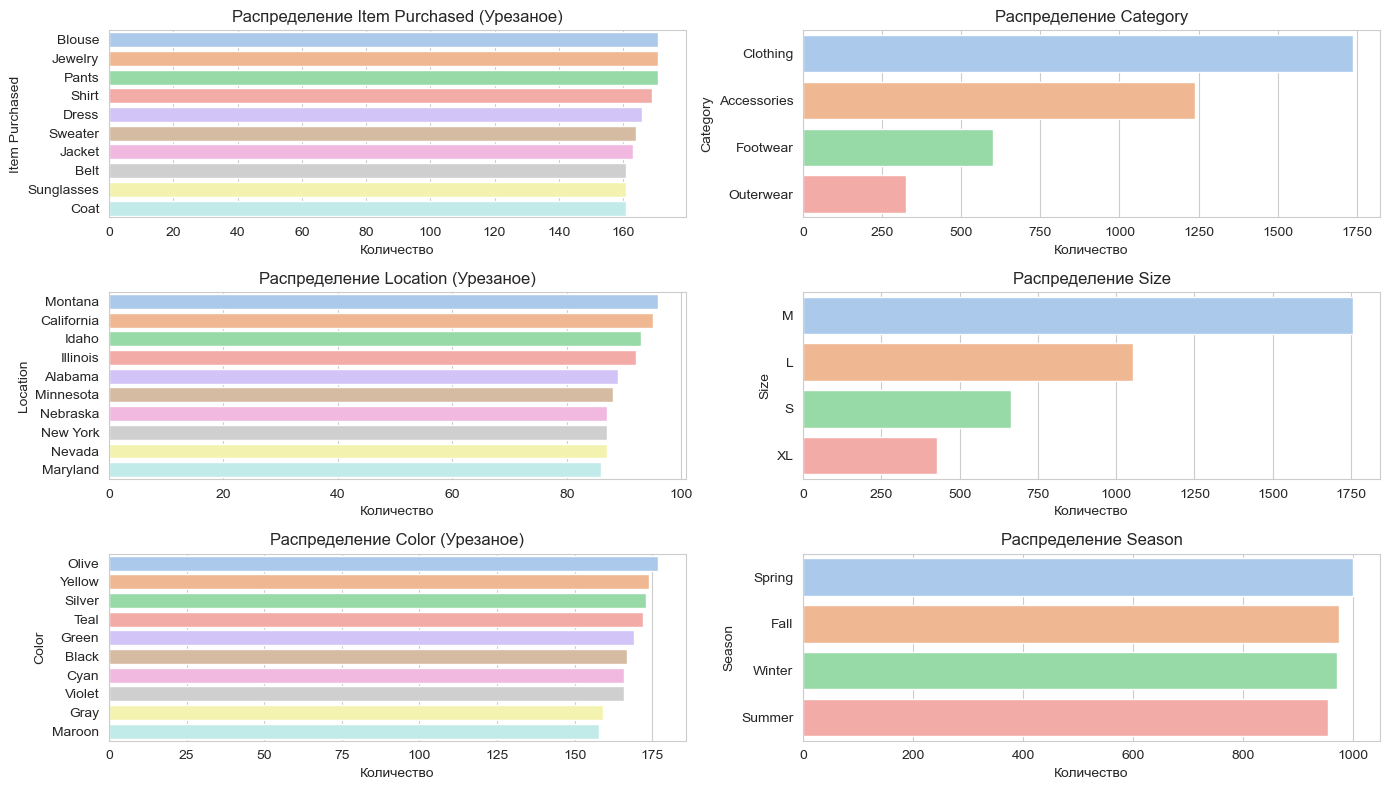

In [71]:
fig, ax = plt.subplots(3, 2, figsize = (14, 8))
columns = ['Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    items = df[column].value_counts().sort_values(ascending=False).index[:10]

    sns.countplot(data=df, y=column, palette='pastel', order=items, ax=ax[row, col])
    if i % 2 == 0:
        ax[row, col].set_title(f'Распределение {column} (Урезаное)')
    else:
        ax[row, col].set_title(f'Распределение {column}')
    ax[row, col].set_xlabel('Количество')
    ax[row, col].set_ylabel(column)
    plt.tight_layout();

#### Хочется проверить гипотезу о том, что в каких-то городах чаще заказывают размер больше или меньше. Проверим с помощью `таблицы сопряженности` и `критерия Хи-квадрат`.

**H0**: *Доли размеров распределены одинаково.*

**H1**: *Доли размеров распределны не одинаково.*

In [102]:
contingency_table = pd.crosstab(df['Location'], df['Size'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-значение для общей таблицы: {p.round(4)}')

P-значение для общей таблицы: 0.5397


По всей таблице результата нет, то есть в среднем во всех штатах доли заказываемых размеров одинаковы. Однако, это не значит, что нет отдельных штатов, в которых будет присутствовать разница. Проведем тестирование на всех штатах отдельно.

In [104]:
results = {}
for location in contingency_table.index:
    observed = contingency_table.loc[location]
    expected = contingency_table.sum(axis=0) / contingency_table.sum().sum() * observed.sum()
    chi2, p, _, _ = chi2_contingency([observed, expected])
    results[location] = {'chi2': chi2, 'p-value': p}

results_df = pd.DataFrame(results).T
results_df['is_significant'] = results_df['p-value'] < 0.05  # Проверяем значимость (α = 0.05)

print(f"Количество штатов, в которых отличная доля размеров: {results_df[results_df['is_significant'] == True].shape[0]}")

Количество штатов, в которых отличная доля размеров: 1


Найден город, в котором доли размеров существенно отличаются от остальных, найдем этот город и узнаем что в нем уникального.


Города с отличными долями
             chi2   p-value  is_significant
Florida  8.180135  0.042432            True


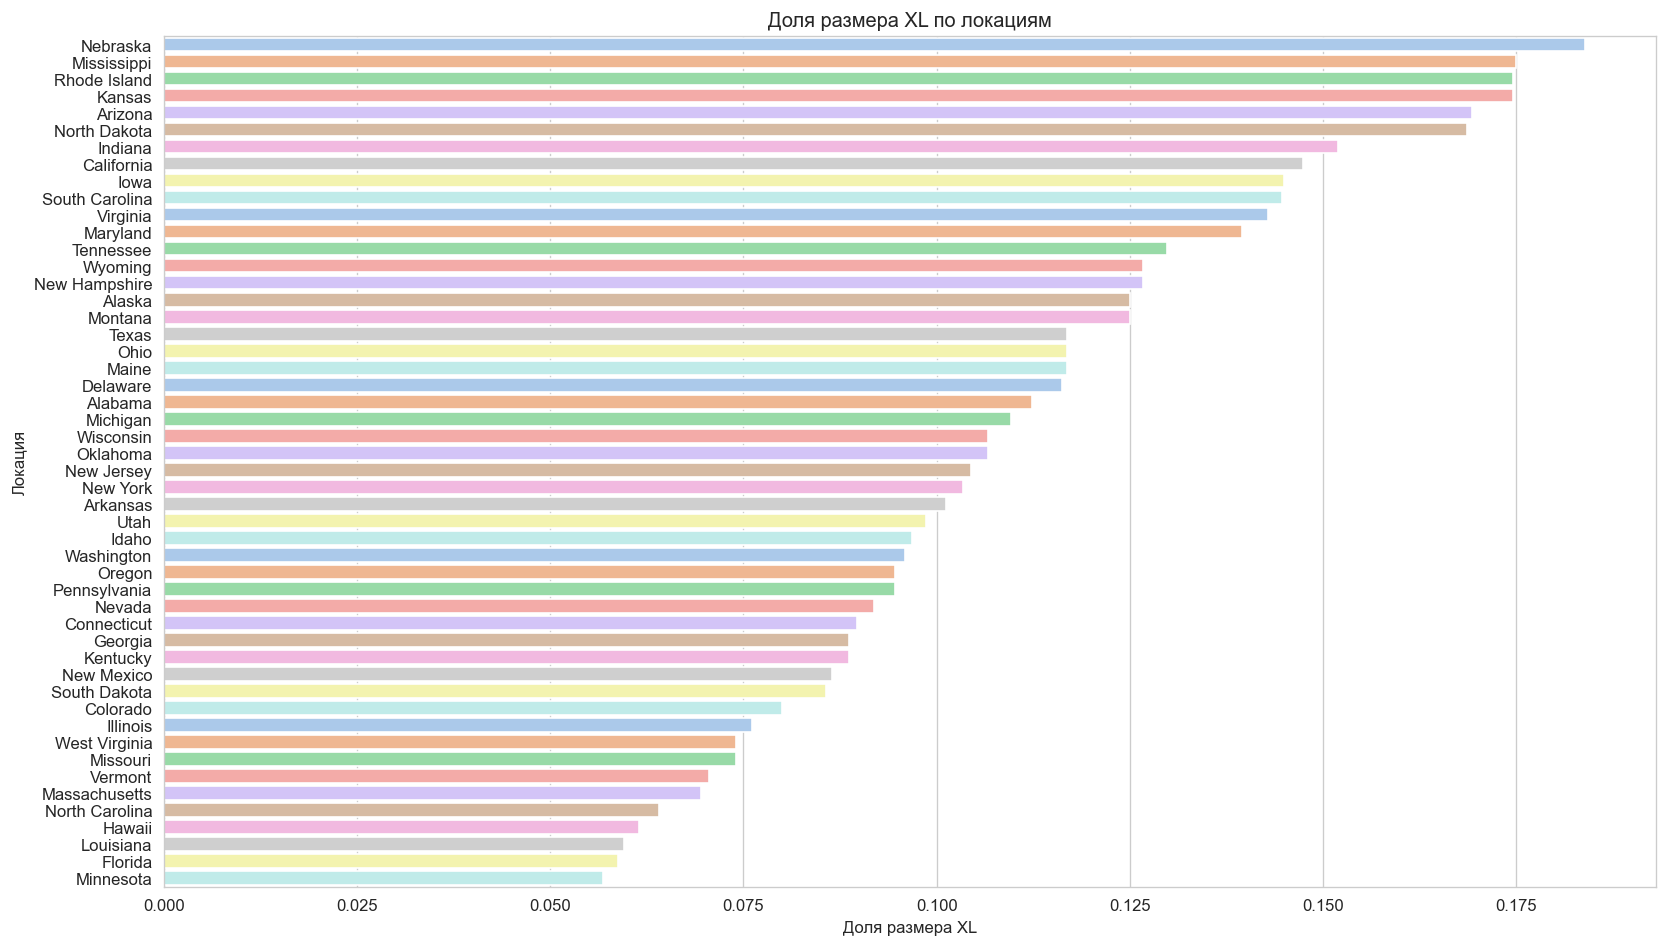

In [105]:
contingency_table['XL_share'] = contingency_table['XL'] / contingency_table.sum(axis=1)

xl_contingency_table = contingency_table.sort_values(by='XL_share', ascending=False)

print("\nГорода с отличными долями")
print(results_df[results_df['is_significant'] == True])

plt.figure(figsize=(14, 8), dpi=120)
sns.barplot(data=xl_contingency_table.reset_index(), x='XL_share', y='Location', palette='pastel')
plt.title('Доля размера XL по локациям')
plt.xlabel('Доля размера XL')
plt.ylabel('Локация')
plt.tight_layout()
plt.show()

Имеем *статистически значимое отличие в штате Флорида от долей в остальных штатых*, однако график показывает, что разницы вызвана не товарами размера XL. Проведем те же действия для размера S.


Города с отличными долями
             chi2   p-value  is_significant
Florida  8.180135  0.042432            True


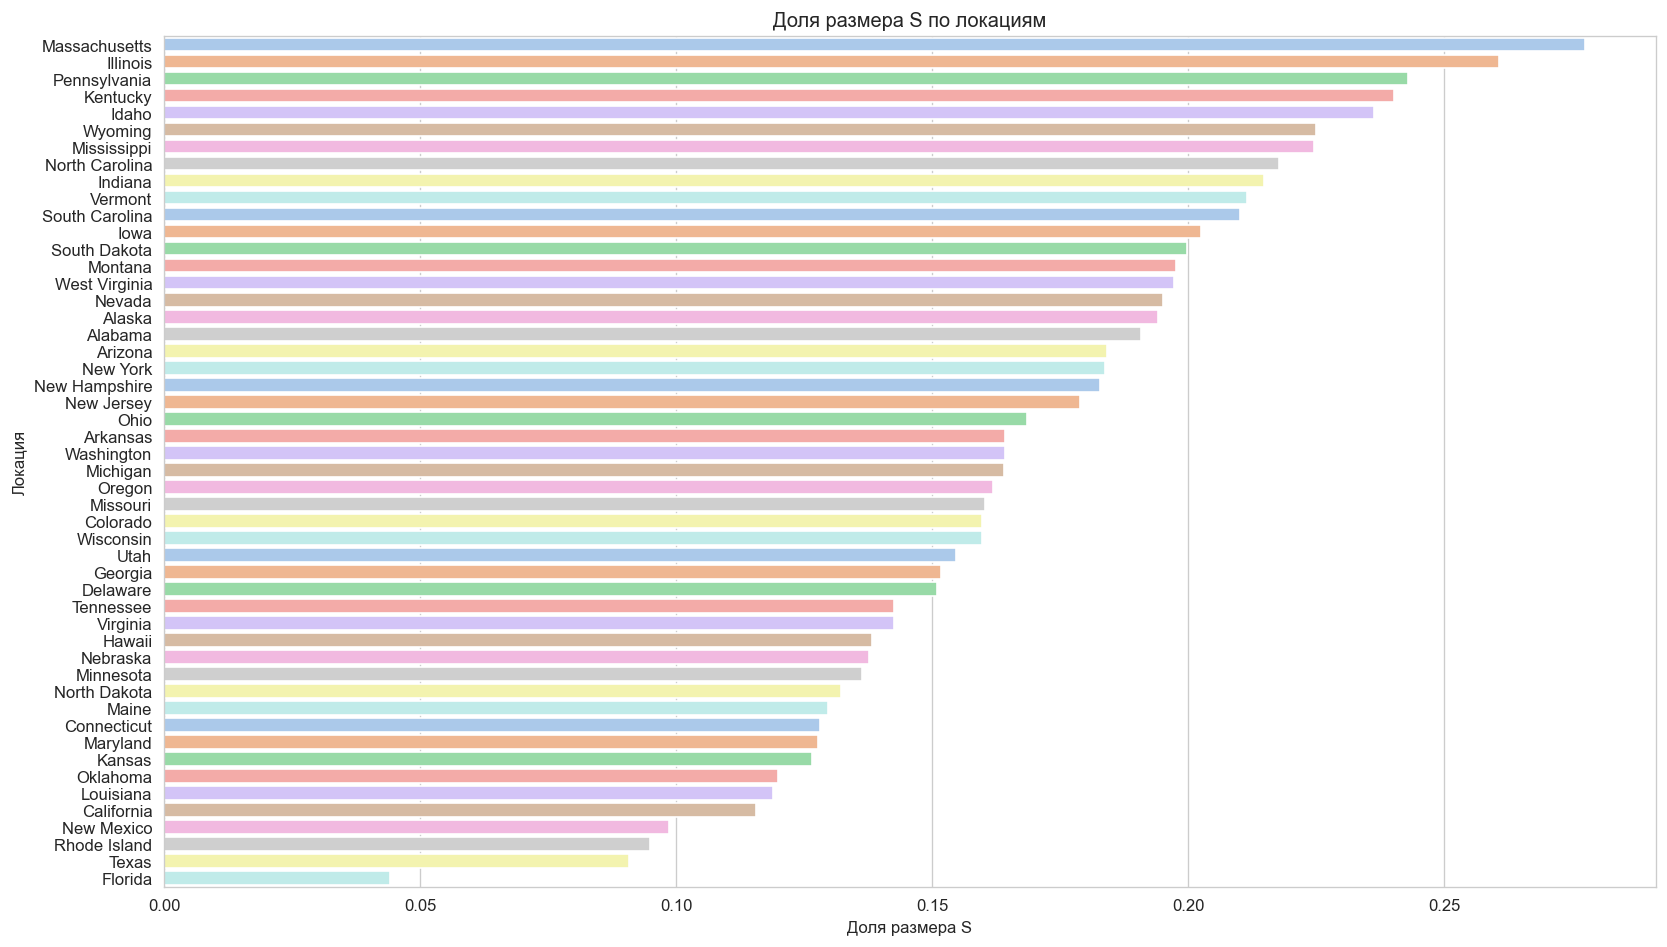

In [106]:
# Вычисляем долю XL для каждой локации
contingency_table['S_share'] = contingency_table['S'] / contingency_table.sum(axis=1)

# Сортируем локации по доле XL
s_contingency_table = contingency_table.sort_values(by='S_share', ascending=False)

print("\nГорода с отличными долями")
print(results_df[results_df['is_significant'] == True])

# Визуализация
plt.figure(figsize=(14, 8), dpi=120)
sns.barplot(data=s_contingency_table.reset_index(), x='S_share', y='Location', palette='pastel')
plt.title('Доля размера S по локациям')
plt.xlabel('Доля размера S')
plt.ylabel('Локация')
plt.tight_layout()
plt.show()

Вот и результат - *статистически значимое отличие для штата Флорида*. Построим круговую диаграмму распределения размеров для Флориды и случайного города из выборки, чтобы подробнее увидеть разницу.

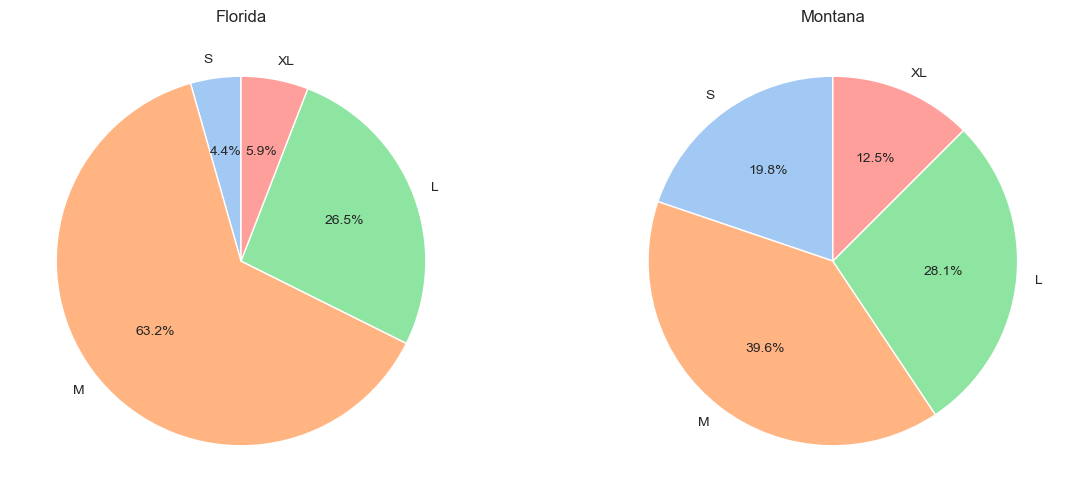

In [109]:
order = ['S', 'M', 'L', 'XL']

florida = df[df['Location'] == 'Florida']
montana = df[df['Location'] == 'Montana']

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

florida_sizes = florida['Size'].value_counts().reindex(order, fill_value=0)
ax[0].pie(florida_sizes, labels=florida_sizes.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=90)
ax[0].set_title('Florida')

montana_sizes = montana['Size'].value_counts().reindex(order, fill_value=0)
ax[1].pie(montana_sizes, labels=montana_sizes.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=90)
ax[1].set_title('Montana');

И вправду заметно, что доля размера S во Флориде существенно меньше, нежели в штате Монтана (и в остальных штатах тоже).

Итого мы можем сказать, что ***штат Флорида уникален - в нем аномально малая доля заказов размера S***.

#### Также хочется проверить наличие связи этих параметров со стоимостью покупки. Используем `попарное сравнение Тьюки для множественного тестирования`. Оно автоматически покажет различающиеся по целевому параметру столбцы.

In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

columns = ['Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season']
for column in columns:
    tukey = pairwise_tukeyhsd(endog=df['Purchase Amount (USD)'], groups=df[column], alpha=0.05)
    print(f'Найдено {str(tukey).count("True")} различающихся параметров в колонке {column}')

Найдено 0 различающихся параметров в колонке Item Purchased
Найдено 0 различающихся параметров в колонке Category
Найдено 0 различающихся параметров в колонке Location
Найдено 0 различающихся параметров в колонке Size
Найдено 1 различающихся параметров в колонке Color
Найдено 2 различающихся параметров в колонке Season


Имеем **статистически значимое различие одной пары в колонке Color и двух пар в колонке Season**. Найдем разные по стоимости цвета и сравним их.

In [50]:
# print(pairwise_tukeyhsd(endog=df['Purchase Amount (USD)'], groups=df['Color'], alpha=0.05))

# Команда показывает результат сравнения для каждой пары, которых довольно много.
# Дабы не засорять ноутбук, я выведу только информацию о различающихся цветах

print('group1    group2  meandiff p-adj   lower    upper  reject')
print('\nGreen Turquoise -10.0903 0.0345 -19.8908 -0.2899   True')

group1    group2  meandiff p-adj   lower    upper  reject

Green Turquoise -10.0903 0.0345 -19.8908 -0.2899   True


Построим распределения цен для этих цветов и соответствующе покрасим графики для наглядности. Также отобразим средние цены.

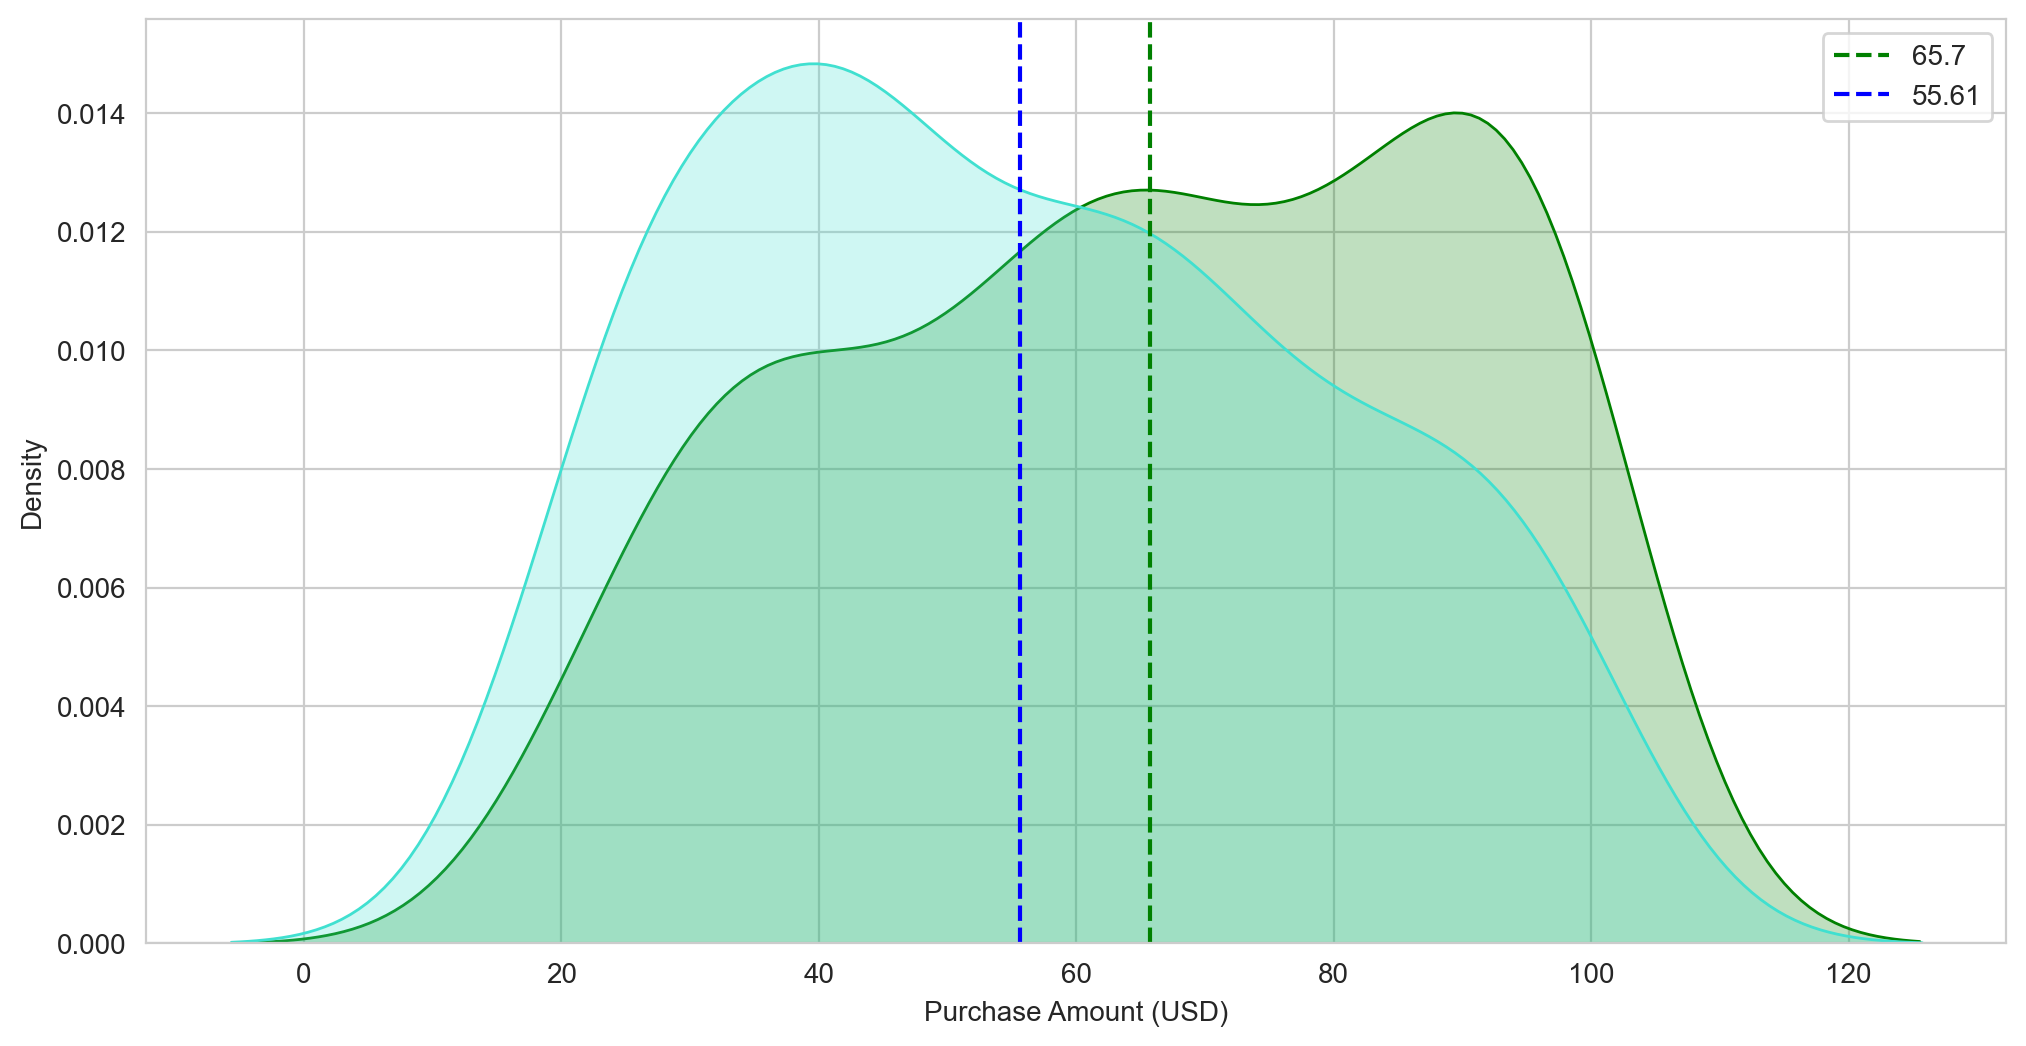

In [48]:
greens = df[df['Color'] == 'Green']['Purchase Amount (USD)']
turquoises = df[df['Color'] == 'Turquoise']['Purchase Amount (USD)']

plt.figure(figsize=(12, 6), dpi=200)
sns.kdeplot(greens, fill=True, color='green')
sns.kdeplot(turquoises, fill=True, color='turquoise')
plt.axvline(greens.mean(), c='green', ls='--', label=greens.mean().round(2))
plt.axvline(turquoises.mean(), c='blue', ls='--', label=turquoises.mean().round(2))
plt.legend();

Не сложно понять, что это граничные значения стоимости разных цветов. То есть в среднем по выборке зеленый - самый дорогой, а бирюзовый - самый дешевый.

***Вывод: абсолютное большинство цветов товара не влияют на стоимость продукта, существенная разница возникает только на граничных значениях.***

#### Также мы помним, что есть 2 пары в ценах товаров в зависимости от сезона. Найдем их.

In [33]:
print(pairwise_tukeyhsd(endog=df['Purchase Amount (USD)'], groups=df['Season'], alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring  -2.8192 0.0407 -5.5568 -0.0816   True
  Fall Summer  -3.1517 0.0182 -5.9202 -0.3831   True
  Fall Winter  -1.1996 0.6783 -3.9566  1.5575  False
Spring Summer  -0.3325 0.9896 -3.0846  2.4196  False
Spring Winter   1.6196 0.4261 -1.1208  4.3601  False
Summer Winter   1.9521 0.2685 -0.8193  4.7235  False
----------------------------------------------------


Итого: *осень отличается от лета и весны. Построим распределения по этим группам и выведем средние значения*.

Winter: 60.36
Spring: 58.74
Summer: 58.41
Fall: 61.56


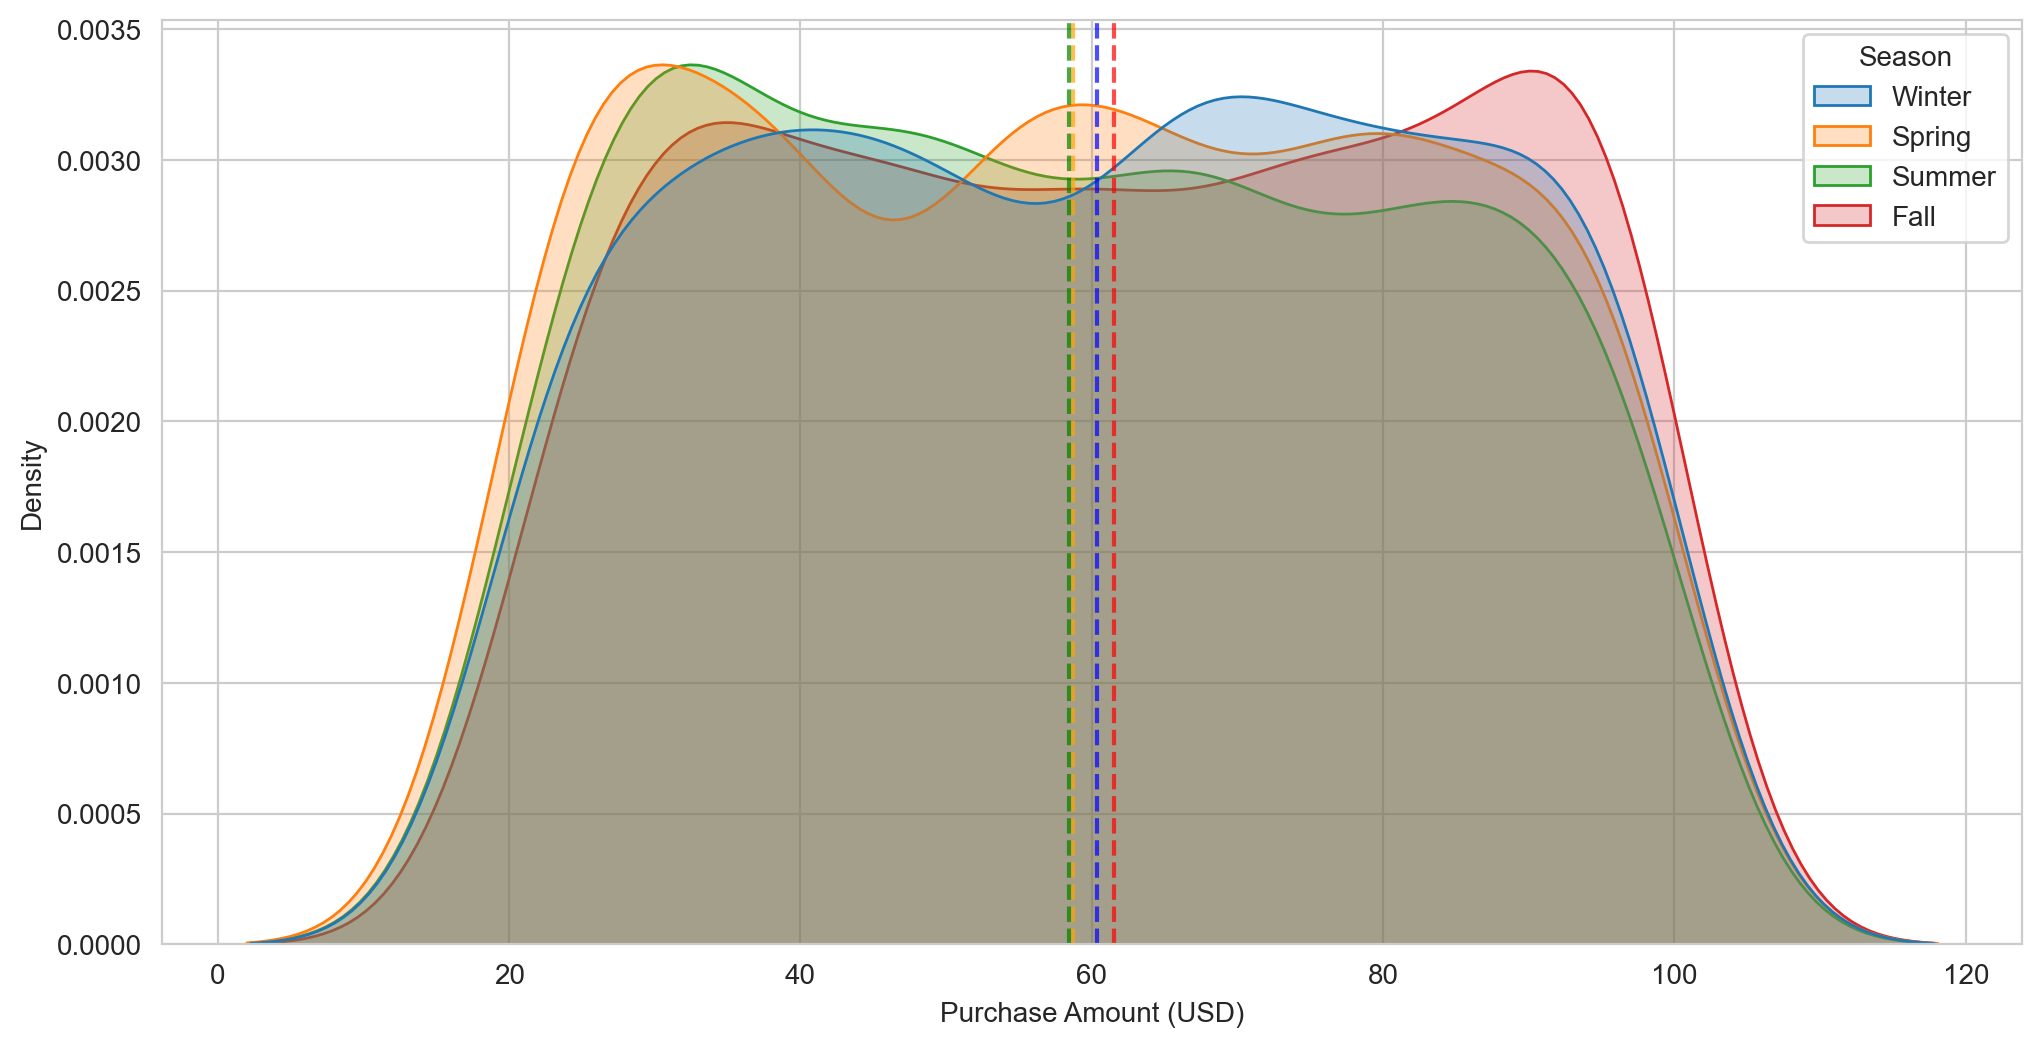

In [56]:
plt.figure(figsize=(12, 6), dpi=200)
sns.kdeplot(data=df, x='Purchase Amount (USD)', hue='Season', fill=True)
colors = ['blue', 'orange', 'green', 'red']
for i, season in enumerate(df['Season'].unique()):
    m = df[df['Season'] == season]['Purchase Amount (USD)'].mean()
    plt.axvline(m, ls='--', c=colors[i], alpha=0.7)
    print(f'{season}: {m.round(2)}');

Это уже интереснее. Оказывается, *средняя стоимость покупки существенно выше осенью и, в сравнении с ней, сильно падает летом и весной.*

Еще раз взглянем на частоту заказов по сезонам.

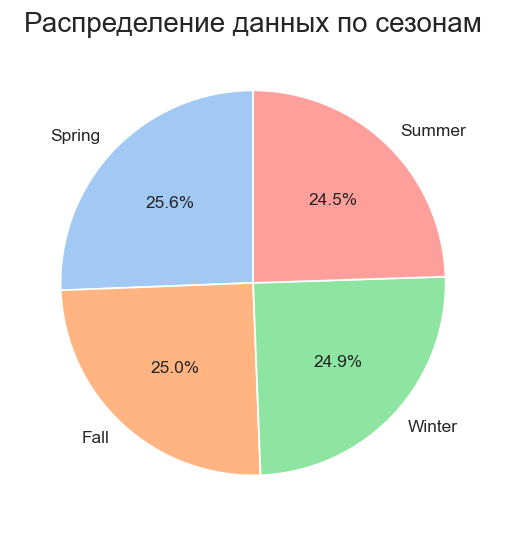

In [14]:
season_counts = df['Season'].value_counts()

# Создание pie plot
plt.figure(figsize=(5, 5), dpi=125)
plt.pie(season_counts, labels=season_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=90)

# Добавление заголовка
plt.title('Распределение данных по сезонам', fontsize=16)

# Отображение графика
plt.show()

Разница не существенна.

***Вывод: при одинаковом количестве заказов по всем сезонам, осенью в среднем покупают товары дороже, а весной и летом дешевле***.

Возможно также пригодится визуализация самых популярных категорий/размеров/цветов и так далее для сезона осени, чтобы дальше продумывать изменения для максимизации прибыли. Построю по всем выше рассмотренным категорям визуализацию.

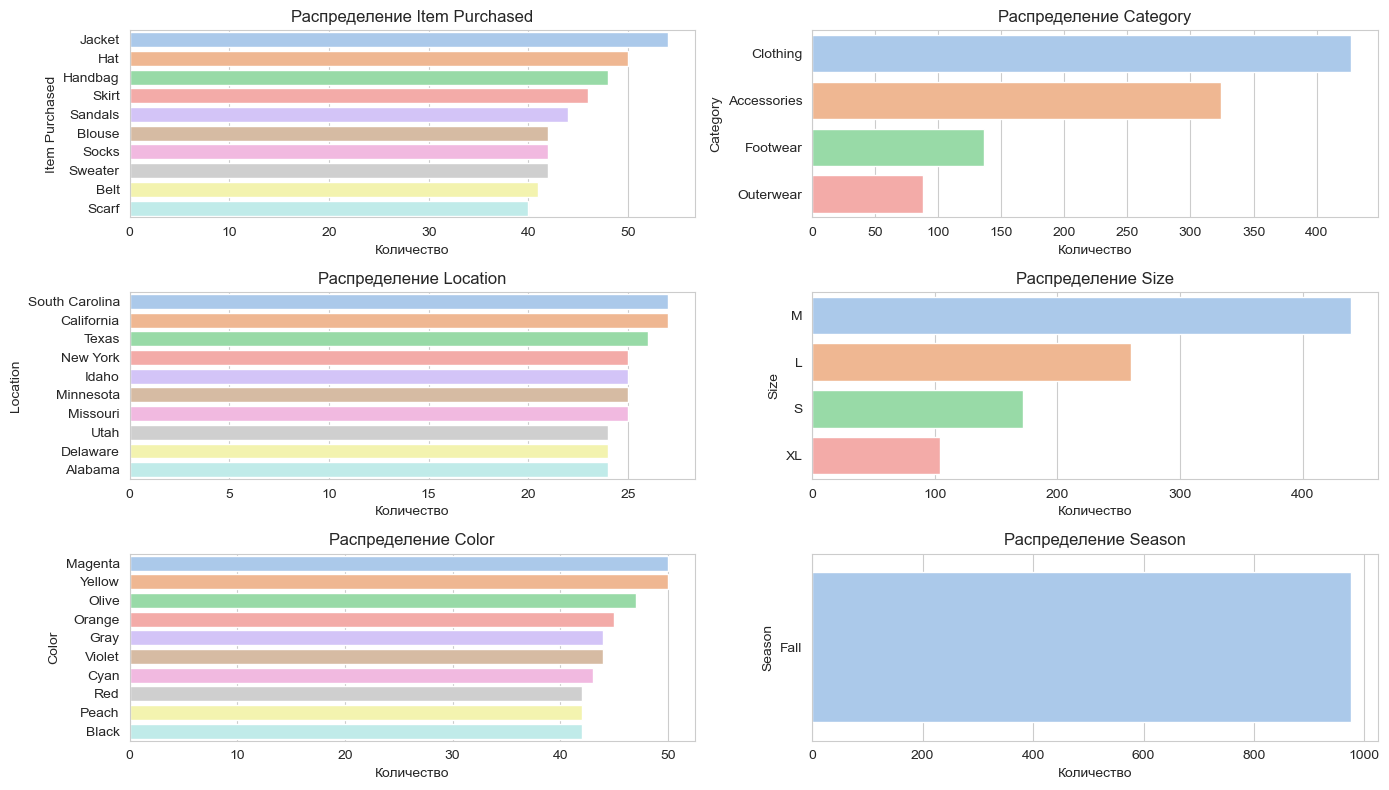

In [41]:
fig, ax = plt.subplots(3, 2, figsize = (14, 8))
columns = ['Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    items = df[df['Season'] == 'Fall'][column].value_counts().sort_values(ascending=False).index[:10]
    
    sns.countplot(y=df[df['Season'] == 'Fall'][column], palette='pastel', order=items, ax=ax[row, col])
    if i % 2 == 0:
        ax[row, col].set_title(f'Распределение {column} (Урез.)')
    else:
        ax[row, col].set_title(f'Распределение {column}')
    ax[row, col].set_title(f'Распределение {column}')
    ax[row, col].set_xlabel('Количество')
    ax[row, col].set_ylabel(column)
    plt.tight_layout();

Этой визуализации должно быть достаточно для построения плана действий, если бы последовала просьба на более глубокий анализ, то можно было бы выявить например причину повышенной цены осенью, но сейчас хочется исследовать остальные взаимосвязи в данных.

#### Также нам интересно узнать как эти группы связаны с оценкой товаров. Проверим также с помощью `теста Тьюки`.

In [47]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

columns = ['Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season']
for column in columns:
    tukey = pairwise_tukeyhsd(endog=df['Review Rating'], groups=df[column], alpha=0.05)
    print(f'Найдено {str(tukey).count("True")} различающихся параметров в колонке {column}')

Найдено 0 различающихся параметров в колонке Item Purchased
Найдено 0 различающихся параметров в колонке Category
Найдено 0 различающихся параметров в колонке Location
Найдено 0 различающихся параметров в колонке Size
Найдено 0 различающихся параметров в колонке Color
Найдено 0 различающихся параметров в колонке Season


Тест не дал результатов, ***эти признаки никак не влияют на оценку товаров***.

#### Еще напрашивается гипотеза: *"Связаны ли тип товара и сезон?"*. Проверим ее с помощью все тех же `Таблицы сопряженности` и критерия `Хи-квадрат`

In [95]:
# Создаём таблицу сопряжённости
contingency_table = pd.crosstab(df['Item Purchased'], df['Season'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-значение для общей таблицы: {p.round(4)}')

# Проводим тест хи-квадрат для каждой локации
results = {}
for location in contingency_table.index:
    observed = contingency_table.loc[location]
    expected = contingency_table.sum(axis=0) / contingency_table.sum().sum() * observed.sum()
    chi2, p, _, _ = chi2_contingency([observed, expected])
    results[location] = {'chi2': chi2, 'p-value': p}

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results).T
results_df['is_significant'] = results_df['p-value'] < 0.05  # Проверяем значимость (α = 0.05)

print(f"Количество товаров, в которых отличная доля сезонов: {results_df[results_df['is_significant'] == True].shape[0]}")

P-значение для общей таблицы: 0.2887
Количество товаров, в которых отличная доля сезонов: 0


Результата нет, ***популярность определенных товаров не меняется с сезоном***.

#### Ну и на последок: "*Связан ли цвет товара и сезон?*"

In [94]:
# Создаём таблицу сопряжённости
contingency_table = pd.crosstab(df['Color'], df['Season'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-значение для общей таблицы: {p.round(4)}')

# Проводим тест хи-квадрат для каждой локации
results = {}
for location in contingency_table.index:
    observed = contingency_table.loc[location]
    expected = contingency_table.sum(axis=0) / contingency_table.sum().sum() * observed.sum()
    chi2, p, _, _ = chi2_contingency([observed, expected])
    results[location] = {'chi2': chi2, 'p-value': p}


results_df = pd.DataFrame(results).T
results_df['is_significant'] = results_df['p-value'] < 0.05

print(f"Количество цветов, в которых отличная доля сезонов: {results_df[results_df['is_significant'] == True].shape[0]}")

P-значение для общей таблицы: 0.7186
Количество цветов, в которых отличная доля сезонов: 0


Нет, ***цвет товара и сезон никак друг с другом не связаны.***

## Анализ столбцов, связанных с работой маркетплейса (способ оплаты/доставки и тд)

В качестве отправной точки построим все те же распределения для признаков.

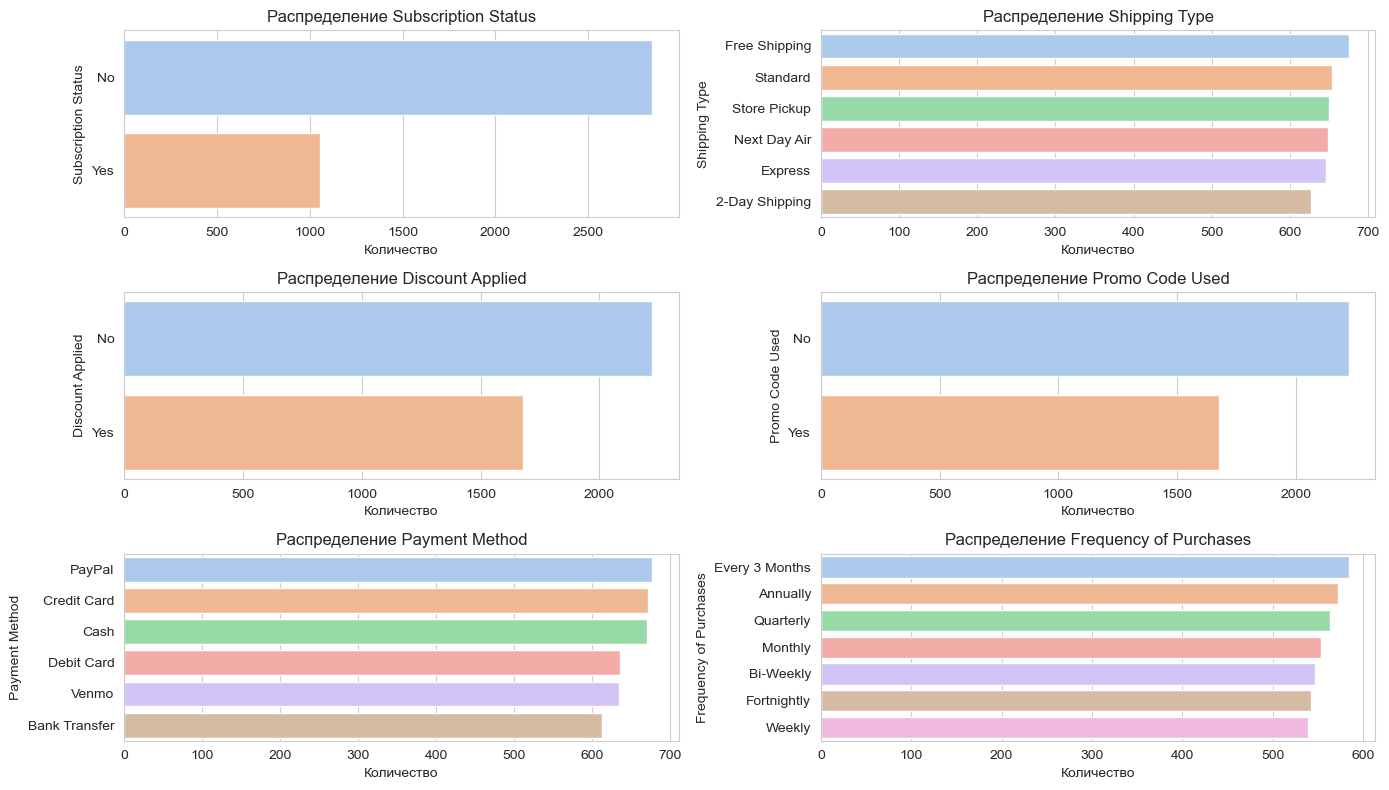

In [73]:
fig, ax = plt.subplots(3, 2, figsize = (14, 8))
columns = ['Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    items = df[column].value_counts().sort_values(ascending=False).index

    sns.countplot(data=df, y=column, palette='pastel', order=items, ax=ax[row, col])
    ax[row, col].set_title(f'Распределение {column}')
    ax[row, col].set_xlabel('Количество')
    ax[row, col].set_ylabel(column)
    plt.tight_layout();

Сразу в глаза бросаются одинаковые графики для *'Discount Applied'* и *'Promo Code Used'*. 

#### Проверим эти признаки на индентичность.

In [56]:
print((df['Discount Applied'] == df['Promo Code Used']).all())

True


И вправду, ***колонки 'Discount Applied' и 'Promo Code Used' дублируют друг друга*** и вполне можно в рамках исследования поставить между ними знак равно.

#### С помощью `теста Тьюки` проверим связь этих признаков с колонкой *'Purchase Amount (USD)'*

In [59]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

columns = ['Subscription Status', 'Shipping Type', 'Discount Applied', 'Payment Method', 'Frequency of Purchases']
for column in columns:
    tukey = pairwise_tukeyhsd(endog=df['Purchase Amount (USD)'], groups=df[column], alpha=0.05)
    print(f'Найдено {str(tukey).count("True")} различающихся параметров в колонке {column}')

Найдено 0 различающихся параметров в колонке Subscription Status
Найдено 0 различающихся параметров в колонке Shipping Type
Найдено 0 различающихся параметров в колонке Discount Applied
Найдено 0 различающихся параметров в колонке Payment Method
Найдено 0 различающихся параметров в колонке Frequency of Purchases


Даже немного странно, но ***все эти признаки никак не влияют на стоимость покупки***, даже примененные промокоды.

#### Как и в прошлый раз проверим связь новых колонок со средней оценкой.

In [89]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

columns = ['Subscription Status', 'Shipping Type', 'Discount Applied', 'Payment Method', 'Frequency of Purchases']
for column in columns:
    tukey = pairwise_tukeyhsd(endog=df['Review Rating'], groups=df[column], alpha=0.05)
    print(f'Найдено {str(tukey).count("True")} различающихся параметров в колонке {column}')

Найдено 0 различающихся параметров в колонке Subscription Status
Найдено 0 различающихся параметров в колонке Shipping Type
Найдено 0 различающихся параметров в колонке Discount Applied
Найдено 0 различающихся параметров в колонке Payment Method
Найдено 0 различающихся параметров в колонке Frequency of Purchases


Также как и в прошлый раз, ***новые признаки не влияют на оценки***.

#### Проверим влияет ли наличие подписки на частоту покупок.

In [93]:
contingency_table = pd.crosstab(df['Frequency of Purchases'], df['Subscription Status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-значение для общей таблицы: {p.round(4)}')

# Проводим тест хи-квадрат для каждой локации
results = {}
for location in contingency_table.index:
    observed = contingency_table.loc[location]
    expected = contingency_table.sum(axis=0) / contingency_table.sum().sum() * observed.sum()
    chi2, p, _, _ = chi2_contingency([observed, expected])
    results[location] = {'chi2': chi2, 'p-value': p}

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results).T
results_df['is_significant'] = results_df['p-value'] < 0.05  # Проверяем значимость (α = 0.05)

print(f"Количество частот покупок, в которых отличная доля подписчиков: {results_df[results_df['is_significant'] == True].shape[0]}")

P-значение для общей таблицы: 0.6909
Количество частот покупок, в которых отличная доля подписчиков: 0


***Значимой связи между частотой покупок и статусом подписки не обнаружено.***

#### Проверим, влияет ли возраст на способ оплаты.

In [65]:
tukey = pairwise_tukeyhsd(endog=df['Age'], groups=df['Payment Method'], alpha=0.05)
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1       group2   meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
Bank Transfer        Cash   0.2162 0.9999 -2.2093 2.6418  False
Bank Transfer Credit Card    0.769 0.9455 -1.6557 3.1937  False
Bank Transfer  Debit Card   0.2079 0.9999 -2.2483 2.6642  False
Bank Transfer      PayPal   0.1637    1.0 -2.2559 2.5832  False
Bank Transfer       Venmo  -0.1704    1.0 -2.6286 2.2878  False
         Cash Credit Card   0.5528 0.9857 -1.8164 2.9219  False
         Cash  Debit Card  -0.0083    1.0 -2.4098 2.3932  False
         Cash      PayPal  -0.0525    1.0 -2.4164 2.3114  False
         Cash       Venmo  -0.3866 0.9975   -2.79 2.0168  False
  Credit Card  Debit Card  -0.5611 0.9856 -2.9617 1.8396  False
  Credit Card      PayPal  -0.6053 0.9782 -2.9683 1.7577  False
  Credit Card       Venmo  -0.9394 0.8755 -3.3419 1.4632  False
   Debit Card      PayPal  -0.0443    1.

***Разницы в возрасте между пользователями разных платежных систем нет.***

#### Может к каким-то категориям товаров применяют промокоды чаще?

In [88]:
contingency_table = pd.crosstab(df['Category'], df['Discount Applied'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-значение для общей таблицы: {p.round(4)}')

results = {}
for location in contingency_table.index:
    observed = contingency_table.loc[location]
    expected = contingency_table.sum(axis=0) / contingency_table.sum().sum() * observed.sum()
    chi2, p, _, _ = chi2_contingency([observed, expected])
    results[location] = {'chi2': chi2, 'p-value': p}

results_df = pd.DataFrame(results).T
results_df['is_significant'] = results_df['p-value'] < 0.05

print(f"Количество категорий, в которых отличная доля примененных промокодов: {results_df[results_df['is_significant'] == True].shape[0]}")

P-значение для общей таблицы: 0.7529
Количество категорий, в которых отличная доля примененных промокодов: 0


***Нет, во всех категориях товаров одинаковое соотношение примененных промокодов.***

## Резюме

Далеко не все поставленные гипотезы подтвердились при детальном анализе, однако были выявлены некоторые закономерности, которые могут помочь маркетплейсу в более узком анализе или максимизации прибыли:
- Соотношение полов пользователей можно принять равным за 2 мужчины на 1 женщину.
- Распределение оценок не равномерно - люди часто округляют оценку до какого-либо приятного числа.
- В среднем у мужчин больше совершенных покупок на 1, нежели у женщин.
- Штат Флорида уникален - в нем аномально малая доля заказов размера S.
- Абсолютное большинство цветов товара не влияют на стоимость продукта, существенная разница возникает только на граничных значениях.
- Осенью в среднем покупают товары дороже, а весной и летом - дешевле.

Телеграм для связи (критики и предложений) - `@Korobans` - Владимир